# Overview of the Corona Cases in Germany - absolute, delta and growth over Time

On base of the data the of the [Berliner Morgenpost](https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/) the following notebook tries to analyze the current Corona situation in Germany.

It shows timelines with 
- absolute covid-19 cases
- absolute growth and 
- growth factor 
for whole Germany and its federal states.

In all the following timelines 
- the dates of measures of the german goverment against corona are marked with a **blue** vertical line, 
- the dates after the mean incubation time thereafter are marked with **red** vertical lines

In all timelines with `confirmed` values only (means: without `recovered, active, deaths`) you also can see  the values for the mean of confirmed cases over 3 days, `called confirmed_mean_3days`. Reason for this is, that the Robert Koch Institute (RKI) as main source for the confirmed statistics in Germany only garantees, that the data are not older than 72h.

### Kudos ..

... to the great Data Team of the [Berliner Morgenpost](https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/), which tirelessly collects current case data and seems to be the best informed source in Germany!!! 


In [89]:
from datetime import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as pyplot

In [90]:
# changeme
START_DATE='05-mar-2020'

## Statistics and Timeline Data

In [91]:
MEAN_INCUBATION_TIME=6 #days

# see https://www.bundesregierung.de/breg-de/themen/coronavirus/coronavirus-1725960
EVENTS = {
    'ESCALATION_EVENTS_LESS_1000_DATE':'10-mar-2020',    
    'BORDERS_CLOSED_DATE':'15-mar-2020',
    'BAR_CLUB_GYM_SHUTDOWN_DATE':'16-mar-2020',
    'KONTAKT_SPERRE_DATE':'23-mar-2020'
}

EVENT_TIMES = [pd.to_datetime(t) for t in EVENTS.values()]

In [92]:
fed_inhabitants = pd.read_csv('./input/de-stats/german-federation-inhabitants.csv', thousands='.', decimal=',')
fed_inhabitants_2018 = fed_inhabitants[['Bundesland','2018']].rename(columns={'2018':'inhabitants_2018'})

## Current Corona Data

In [93]:
CURRENT_DATA_URL='https://funkeinteraktiv.b-cdn.net/current.v3.csv'
HISTORY_DATA_URL='https://funkeinteraktiv.b-cdn.net/history.v3.csv'

In [94]:
df = pd.read_csv(HISTORY_DATA_URL)
df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")

LATEST_DATE = df.date.max() - pd.Timedelta(days=1) # current day may not have been reported

history_df = df[(df.date>pd.to_datetime(START_DATE)) & (df.date<=LATEST_DATE)]

# German Data

In [95]:
de_history_df = history_df.loc[history_df.label_parent=='Deutschland',['label','date','recovered','confirmed','deaths']]

In [96]:
de_history_df['active'] = de_history_df['confirmed'] - (de_history_df['recovered'] + de_history_df['deaths'])

In [97]:
de_by_date = de_history_df.groupby('date').sum()

## Absolute German Cases

In [98]:
def plot_events_x(ax, ypos):
    for event, event_date in EVENTS.items():
        ax.axvline(event_date, color="blue", linestyle="--")
        pyplot.text(event_date,ypos,event,rotation=90)
        
def earliest_effect_date (event_date: str):
    return pd.to_datetime(event_date) + pd.Timedelta(days=MEAN_INCUBATION_TIME)        
        
def plot_events(ax, ypos):
    i = 1
    for event, event_date in EVENTS.items():
        ax.axvline(event_date, color="blue", linestyle="--")        
        pyplot.text(event_date,ypos,"({}) {}".format(i,event),rotation=90, color='blue')

        earliest_effect = earliest_effect_date(event_date)
        if earliest_effect < LATEST_DATE:
            ax.axvline(earliest_effect, color="red", linestyle="--")     
            if earliest_effect in EVENT_TIMES:
                text = "({})".format(i)
                y = 0
            else:              
                text = "({}) {}".format(i,event)
                y = ypos
            pyplot.text(earliest_effect,y,text,rotation=90, color='red') 
        i += 1

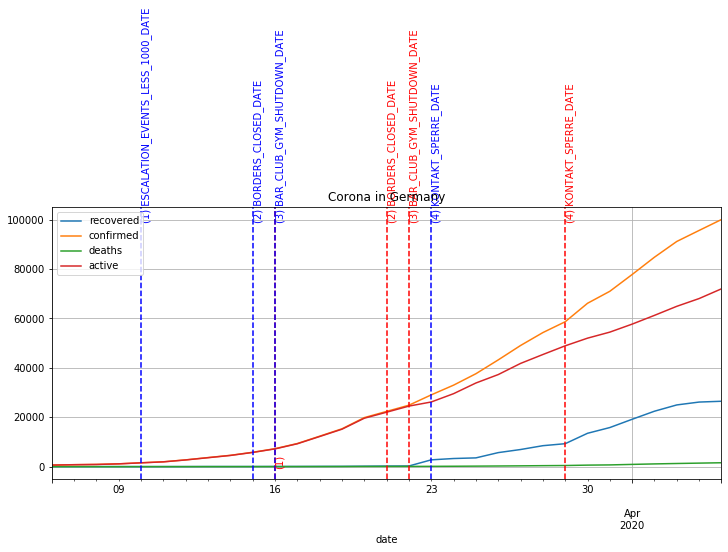

In [99]:
ax=de_by_date.plot(figsize=(12,5), title='Corona in Germany')
plot_events(ax, de_by_date.confirmed.max())
pyplot.grid(True);

## Absolute Growth

### Utilities

In [100]:
def abs_growth_from(df_by_date):
    return df_by_date.diff().fillna(0)

def plot_abs_growth(df_abs_growth,details="", max_y=None):
    max_y = max_y if max_y else df_abs_growth.max().max()
    ax = df_abs_growth.plot(figsize=(12,4), title='Absolute Confirmed Growth (1st derivate):'+details, ylim=(0,max_y))
    pyplot.ylabel('Delta to day before');
    pyplot.grid(True)
    return ax
    
def plot_abs_growth_confirmed(df_abs_growth,details=""):
    df=df_abs_growth[['confirmed']]  
    df['confirmed_mean_3days'] = df.rolling(3).mean()  
    ax = df.plot(figsize=(12,4), title='Absolute Growth (1st derivate):'+details)
    pyplot.ylabel('Delta to day before');
    pyplot.grid(True)    
    return ax

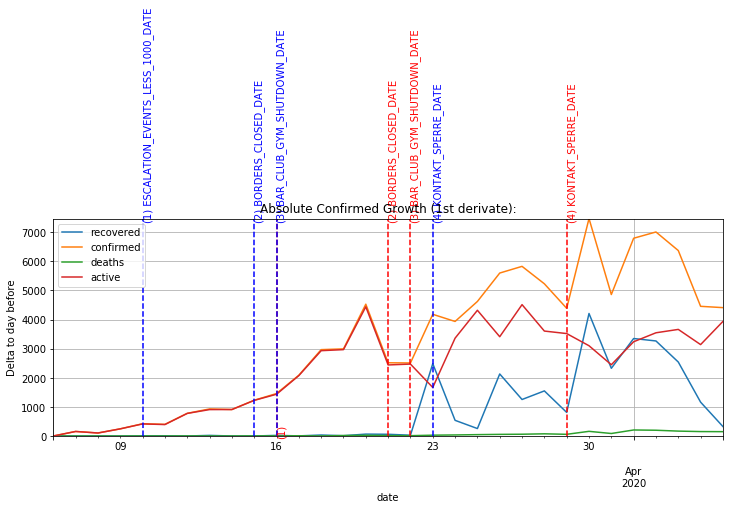

In [101]:
abs_growth_de_by_date = abs_growth_from(de_by_date)
ax = plot_abs_growth(abs_growth_de_by_date)
plot_events(ax, abs_growth_de_by_date.max().max()-10)

## Growth Factor


<img src="https://i1.wp.com/feld.com/wp-content/uploads/2020/03/Screen-Shot-2020-03-10-at-10.18.51-AM.png?resize=768%2C451&ssl=1" width="500px">Growth Factor</img>

see [Exponential Growth and Covid-19](https://feld.com/archives/2020/03/exponential-growth-and-covid-19.html)
and [Kaggle contribution of dferhadi](https://www.kaggle.com/dferhadi/covid-19-growth-factor-visualization-and-calculus)

> the growth factor can be used to estimate the lifespan of the growth. 
> When the growth factor for the spread is 1.0 this can be a sign that we have hit the inflection point.

> ... The inflection point is where the curve changes concavity.

### Utilities

In [102]:
def growth_factor_from(df):
    return (df/ df.shift(1))

def plot_growth_factor(growth_factor_df, max_growth=10, details=""):
    ax = growth_factor_df.plot(figsize=(12,6), linestyle=':', linewidth=2, title='Growth Factor Confirmed (2nd derivate):' + details, ylim=(0,max_growth))
    ax.axhline(y=1, color='red', linestyle='--')
    pyplot.grid(True)
    pyplot.ylabel('Delta today/Delta day before');
    return ax     

In [103]:
abs_growth = abs_growth_from(de_by_date)[['confirmed']]
abs_growth['confirmed_mean_3days'] = abs_growth.rolling(3).mean()  

growth_factors = growth_factor_from(abs_growth)
max_growth = growth_factors[growth_factors<10].max().max()

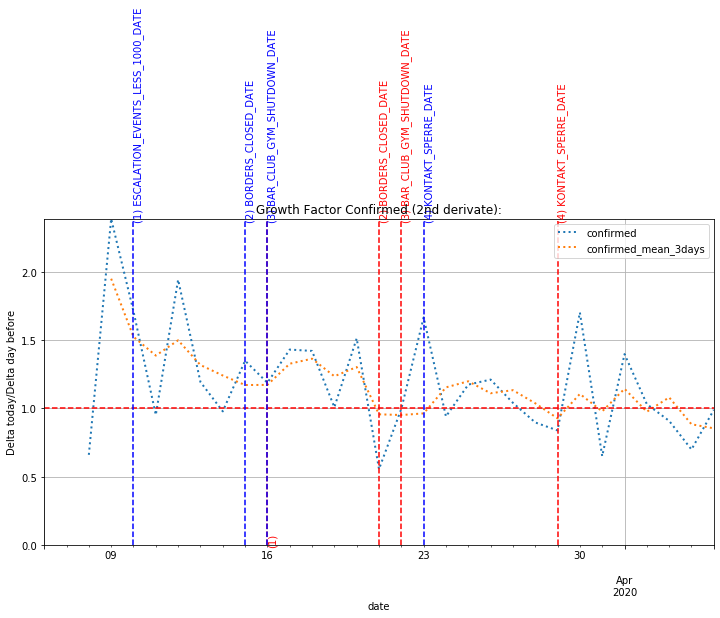

In [104]:
ax = plot_growth_factor(growth_factors,max_growth)
plot_events(ax, max_growth)

# German Federal States

In [105]:
de_fed_by_date_all = de_history_df.groupby(['date','label']).sum().reset_index()
#feds = list(de_fed_by_date_all.label.unique())
feds = ['Baden-Württemberg',
 'Bayern',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'Hamburg',
 'Hessen',
 'Mecklenburg-Vorpommern',
 'Niedersachsen',
 'Nordrhein-Westfalen',
 'Rheinland-Pfalz',
 'Saarland',
 'Sachsen',
 'Sachsen-Anhalt',
 'Schleswig-Holstein',
 'Thüringen']

de_fed_by_date = de_fed_by_date_all[de_fed_by_date_all.label.isin(feds)]

## Absolute Cases

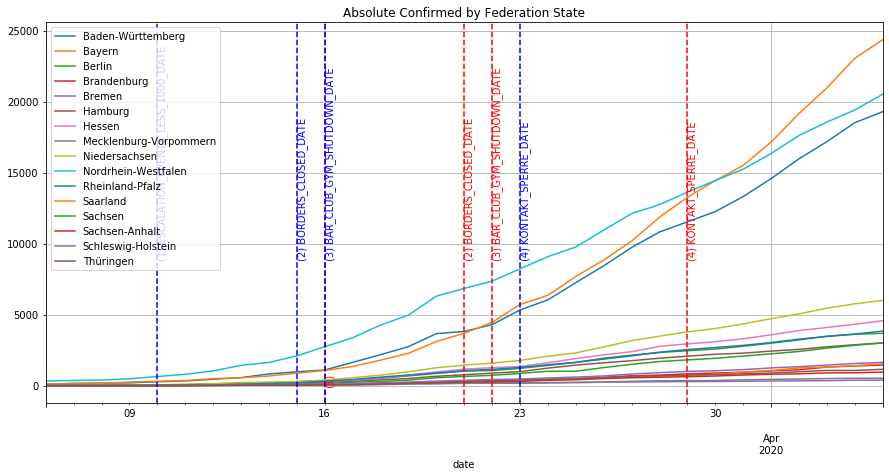

In [106]:
de_fed_by_date.set_index(['date']).groupby('label')['confirmed'].plot(figsize=(15,7), legend=True, title='Absolute Confirmed by Federation State')
plot_events(pyplot.gca(),9000)
pyplot.grid(True);

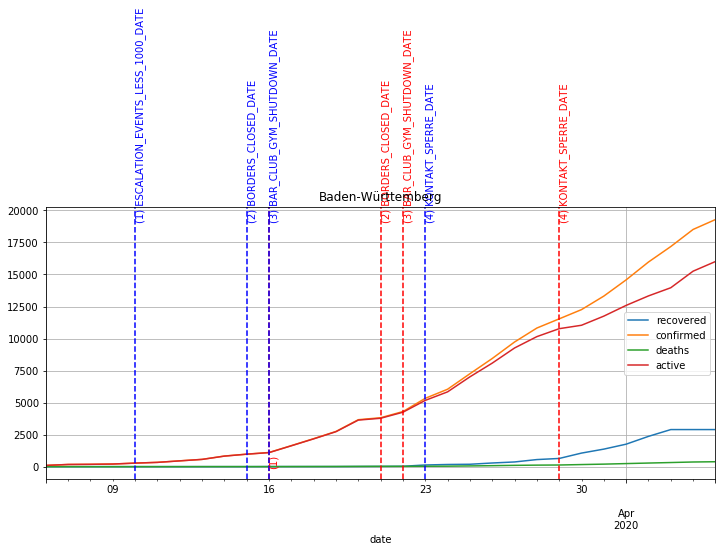

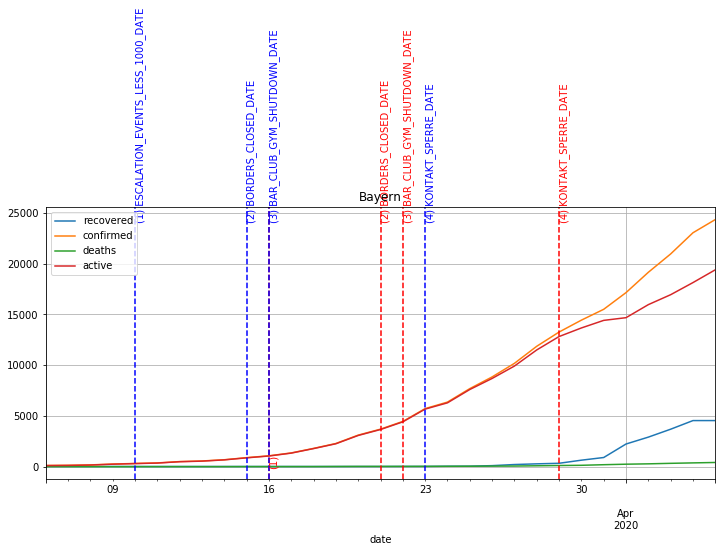

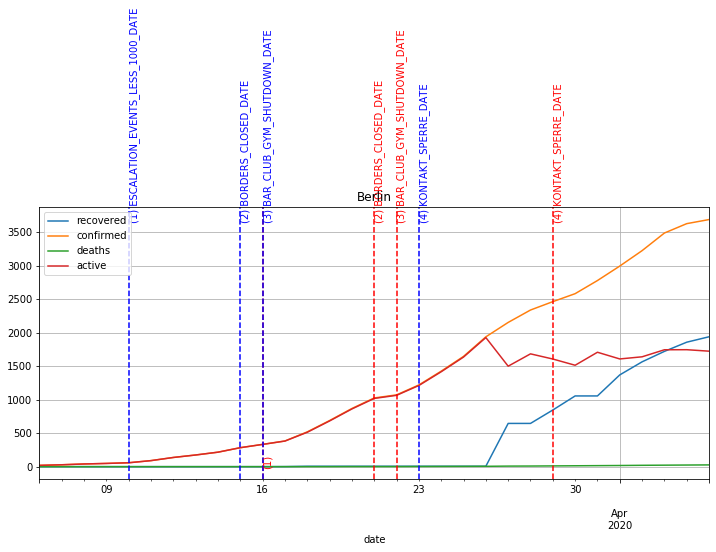

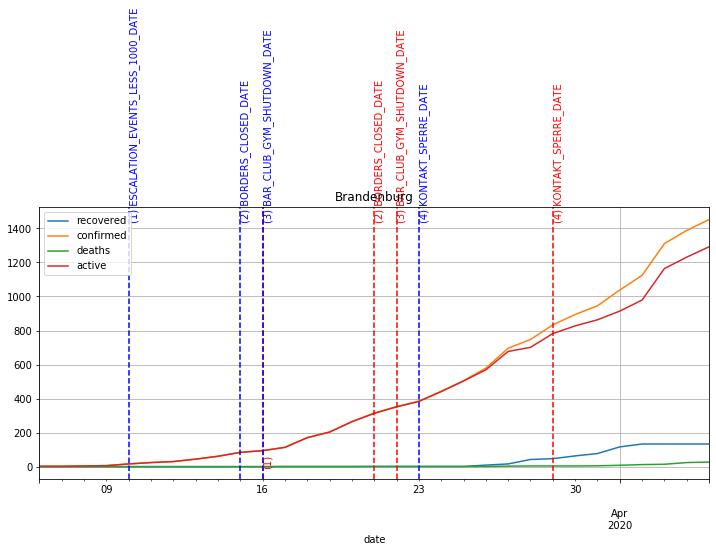

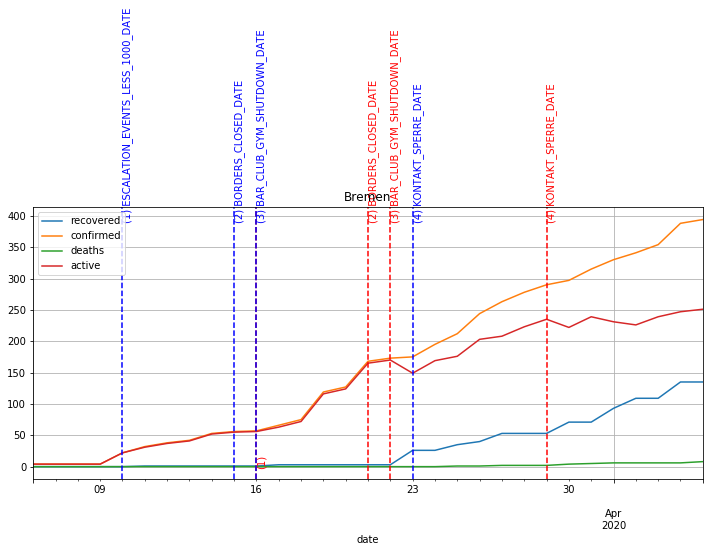

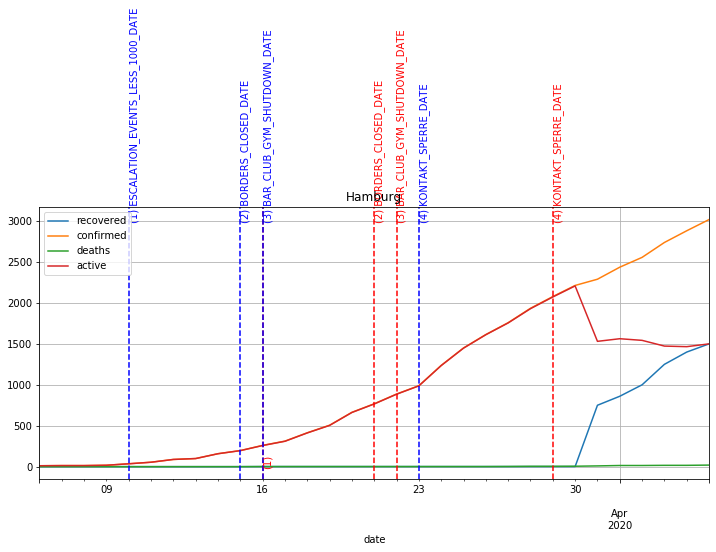

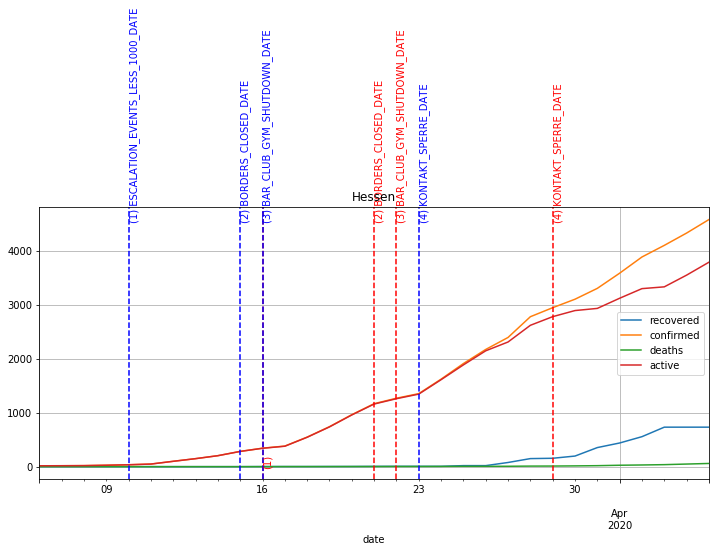

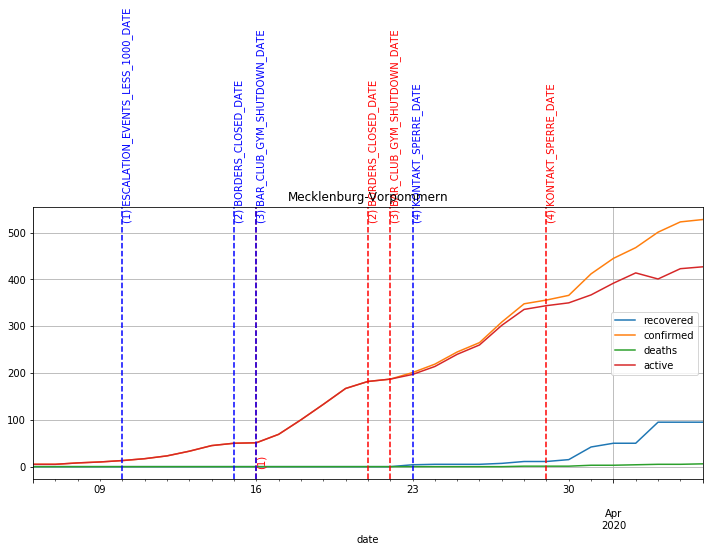

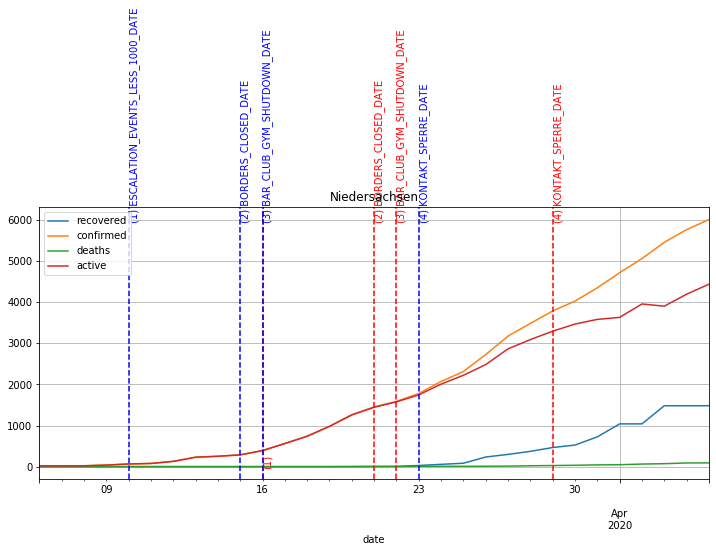

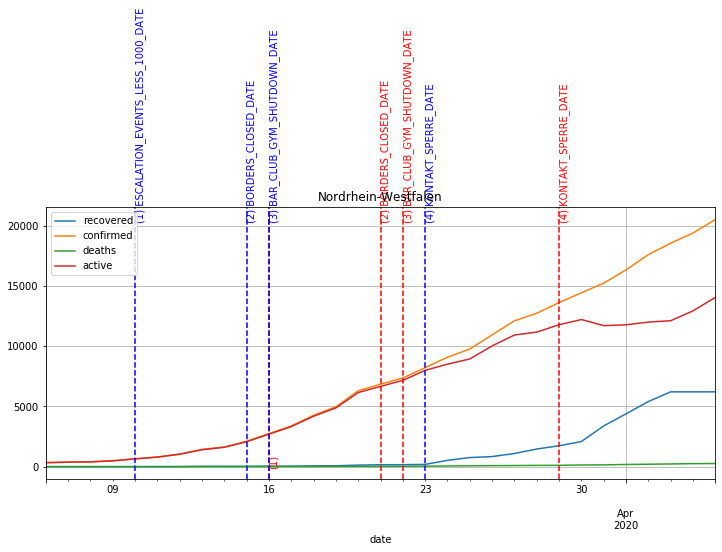

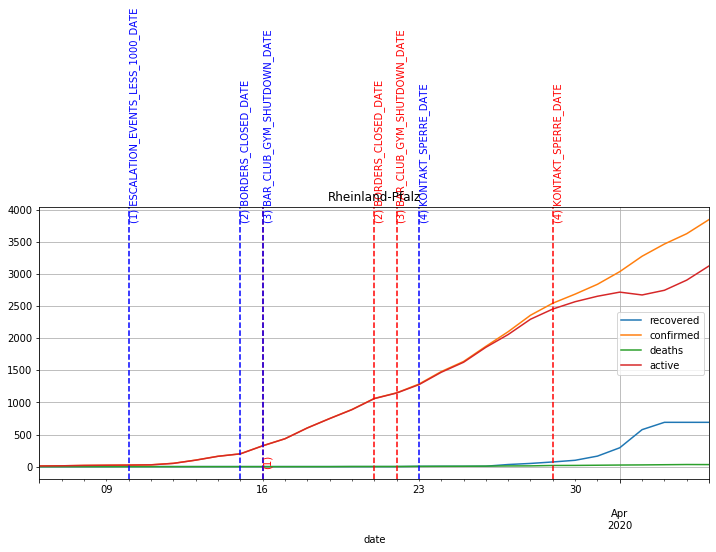

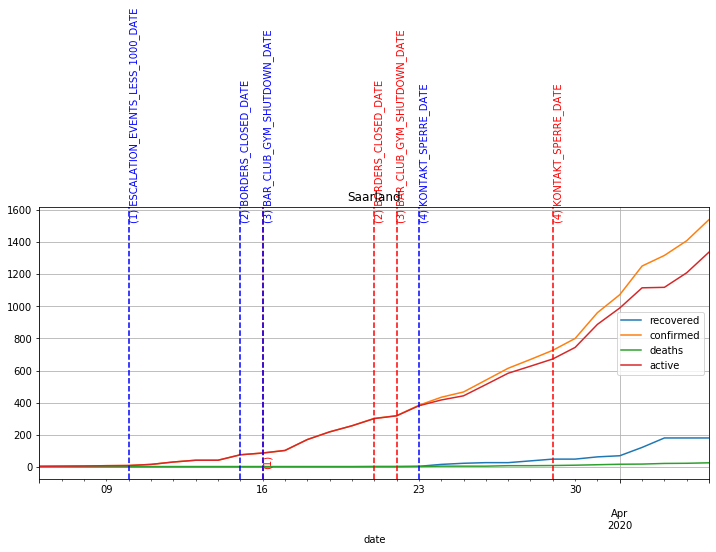

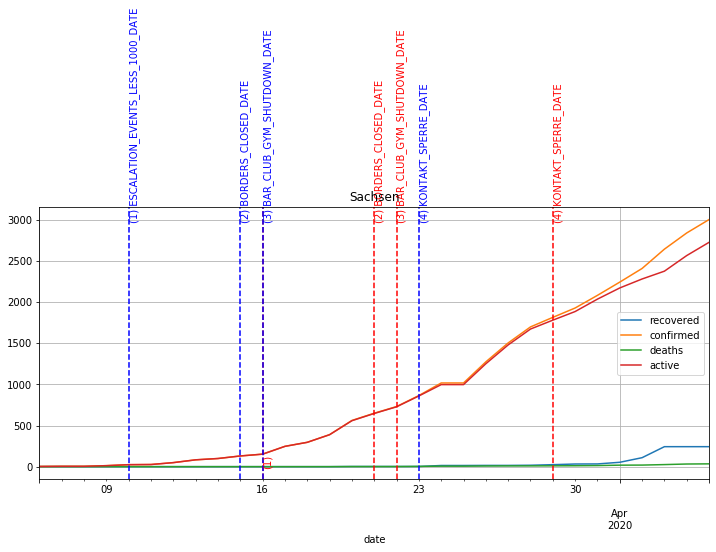

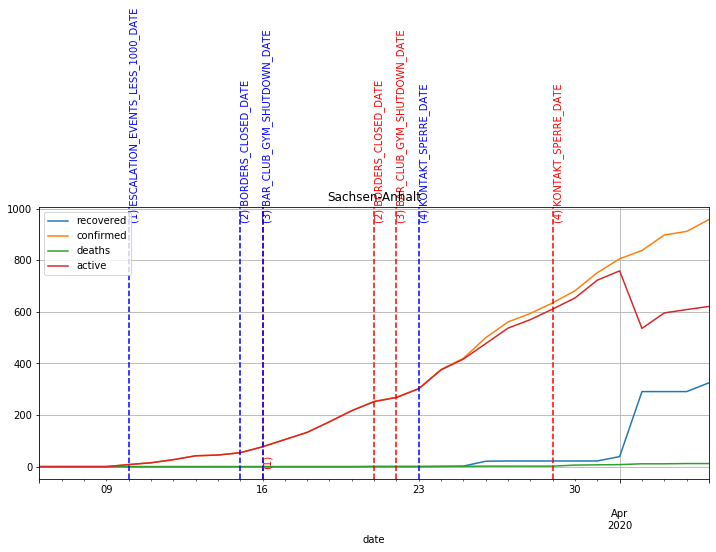

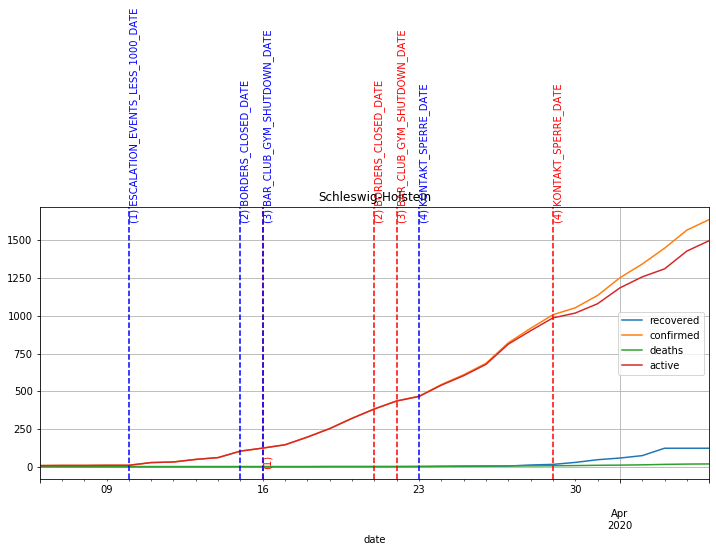

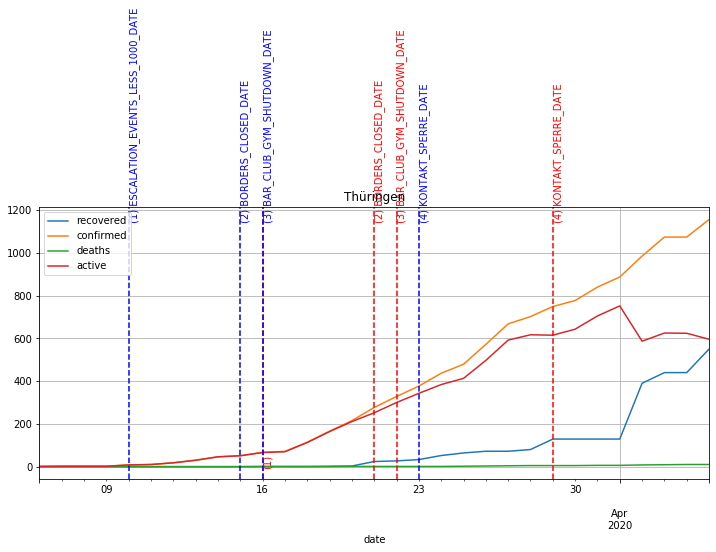

In [107]:
for fed in feds:
    df = de_fed_by_date.loc[de_fed_by_date.label==fed].set_index('date')
    ax = df.plot(figsize=(12,5), title=fed)
    plot_events(ax,df.confirmed.max())
    pyplot.grid(True)

## Fed Cases per 10000 Inhabitants

In [108]:
PER_INHABITANTS = 100000

In [109]:
de_fed_by_date_w_inhabitants = pd.merge(de_fed_by_date.rename ({"label":"Bundesland"}, axis=1), fed_inhabitants_2018, on='Bundesland', how='inner').set_index(['date','Bundesland'])

### Confirmed

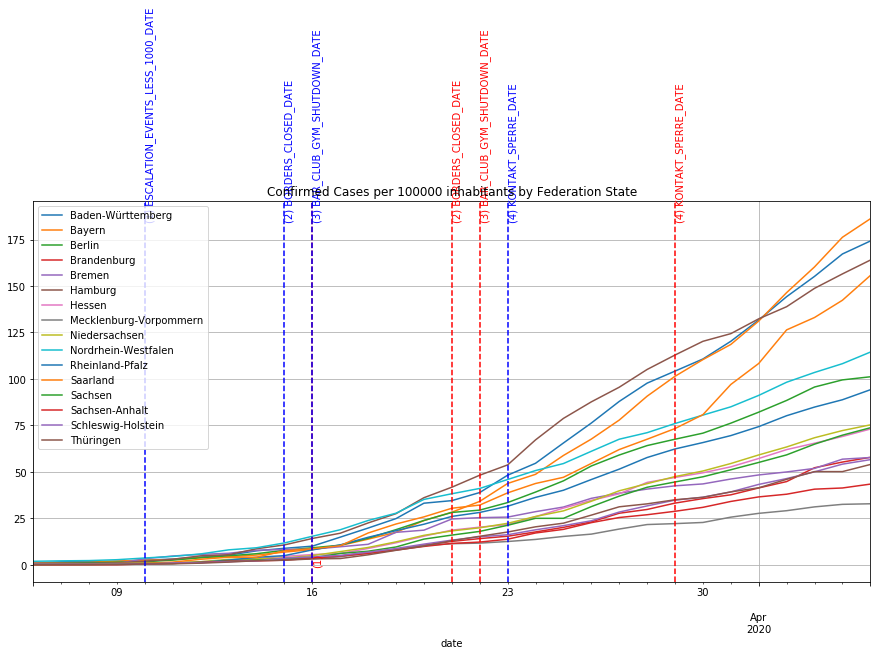

In [110]:
confirmed_per_inhabitants = (de_fed_by_date_w_inhabitants['confirmed']*PER_INHABITANTS)/de_fed_by_date_w_inhabitants['inhabitants_2018']

confirmed_per_inhabitants.to_frame().reset_index().set_index(['date']).groupby('Bundesland')[0].plot(figsize=(15,7), legend=True, title='Confirmed Cases per {} inhabitants by Federation State'.format(PER_INHABITANTS))
plot_events(pyplot.gca(),confirmed_per_inhabitants.max())
pyplot.grid(True);

### Active

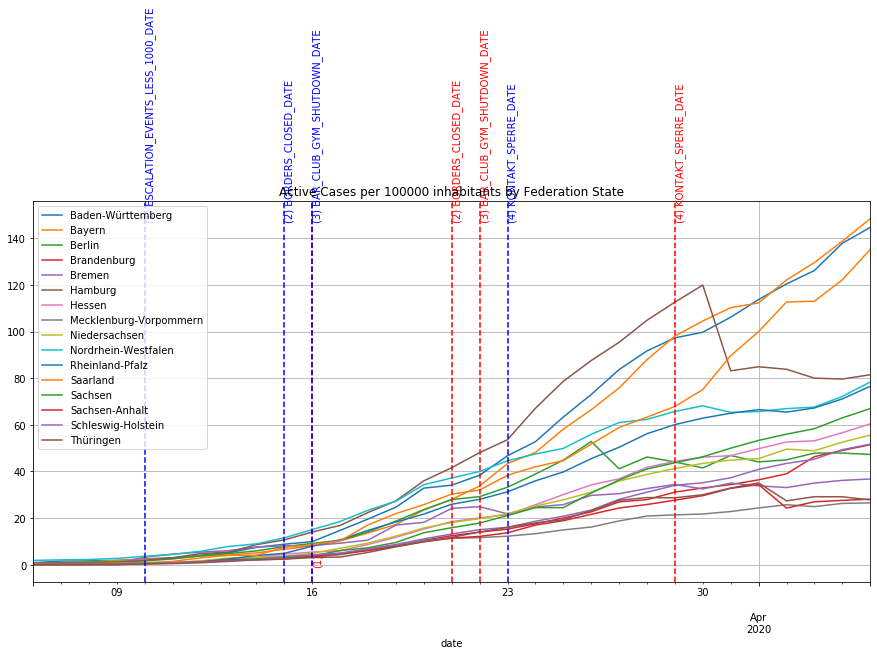

In [111]:
active_per_inhabitants = (de_fed_by_date_w_inhabitants['active']*PER_INHABITANTS)/de_fed_by_date_w_inhabitants['inhabitants_2018']

active_per_inhabitants.to_frame().reset_index().set_index(['date']).groupby('Bundesland')[0].plot(figsize=(15,7), legend=True, title='Active Cases per {} inhabitants by Federation State'.format(PER_INHABITANTS))
plot_events(pyplot.gca(),active_per_inhabitants.max())
pyplot.grid(True);

## Absolute Growth

In [112]:
confirmed_df_diff = de_fed_by_date.set_index(['date','label'])['confirmed'].unstack().diff()

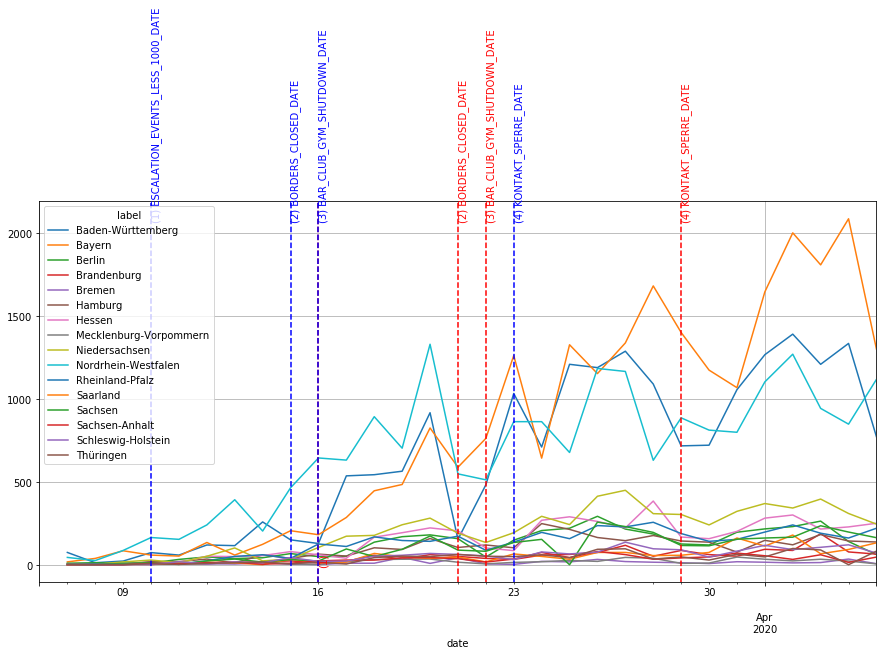

In [113]:
ax = confirmed_df_diff.plot(figsize=(15,7), legend=True)
plot_events(ax,confirmed_df_diff.max().max())
pyplot.grid(True);

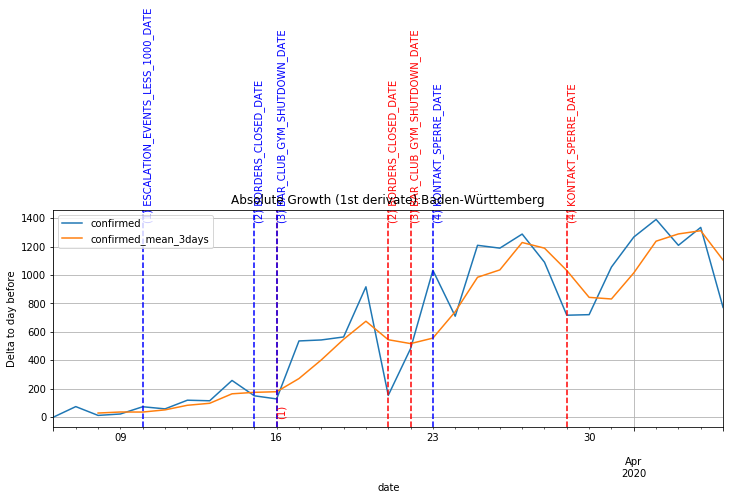

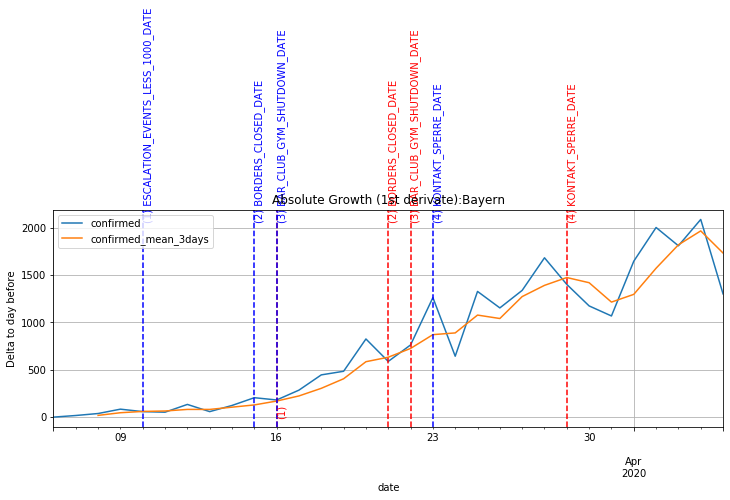

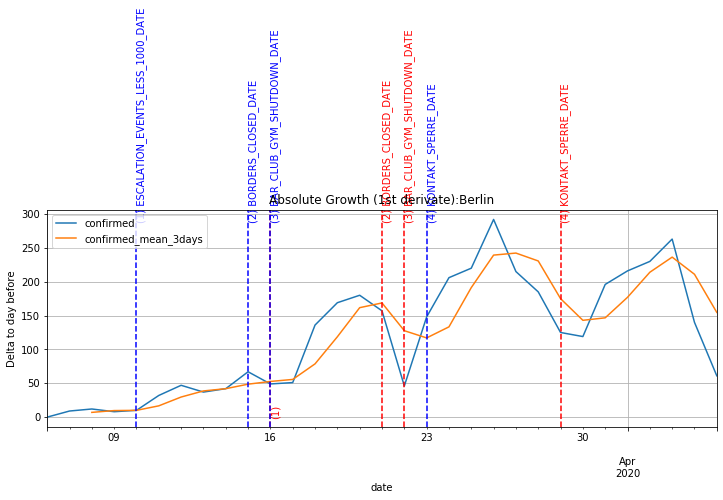

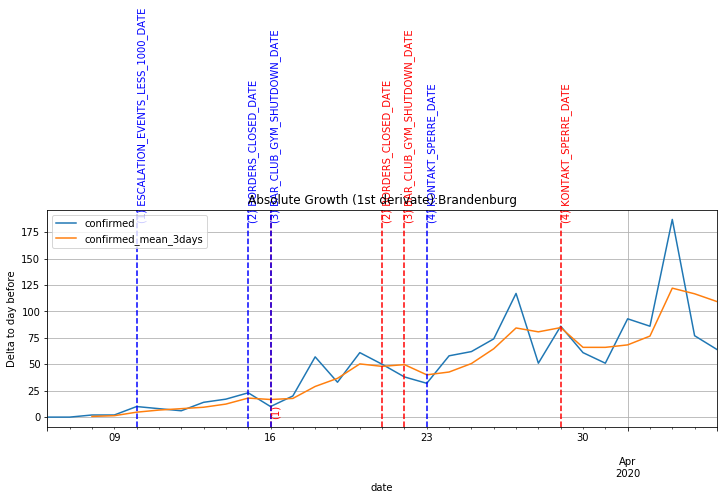

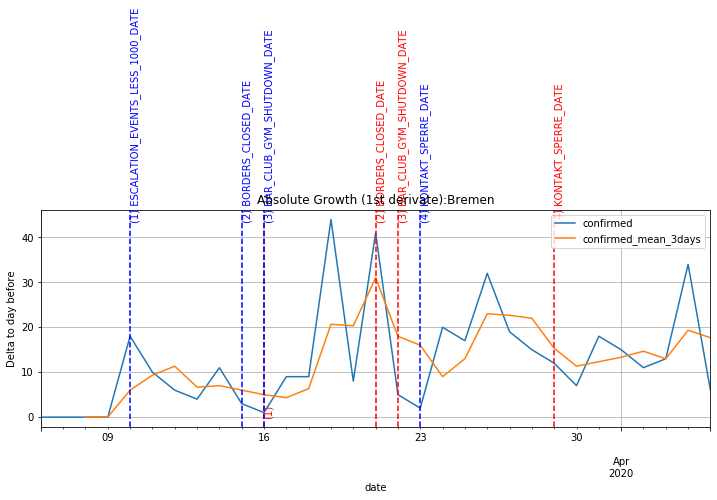

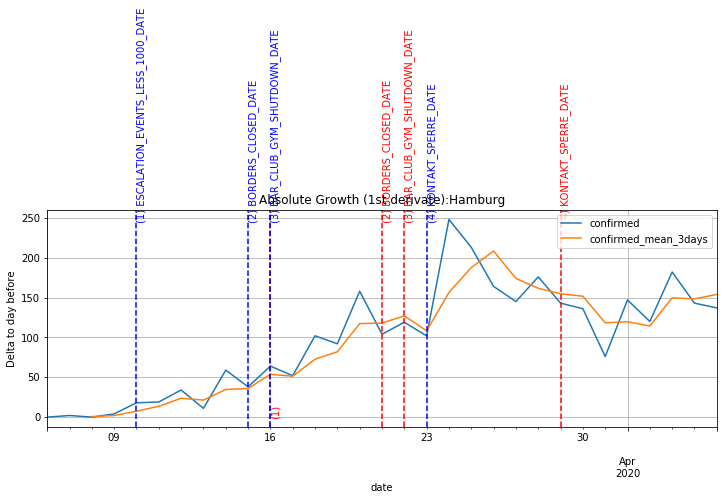

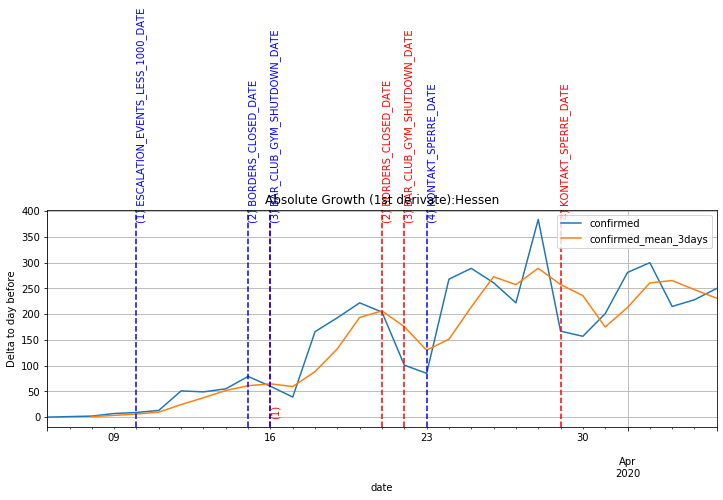

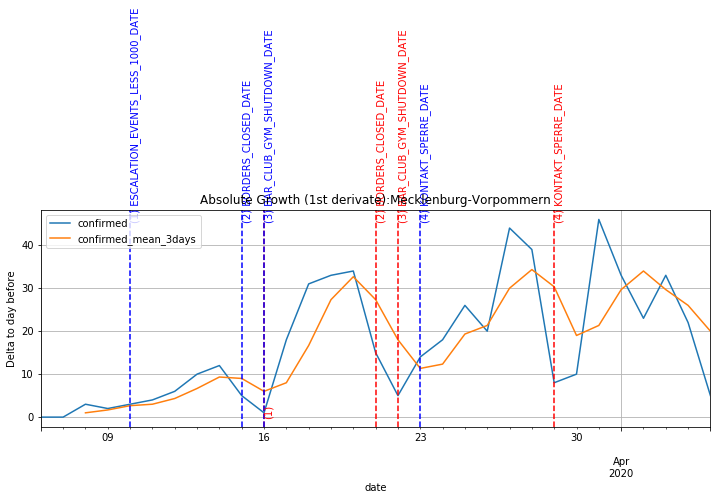

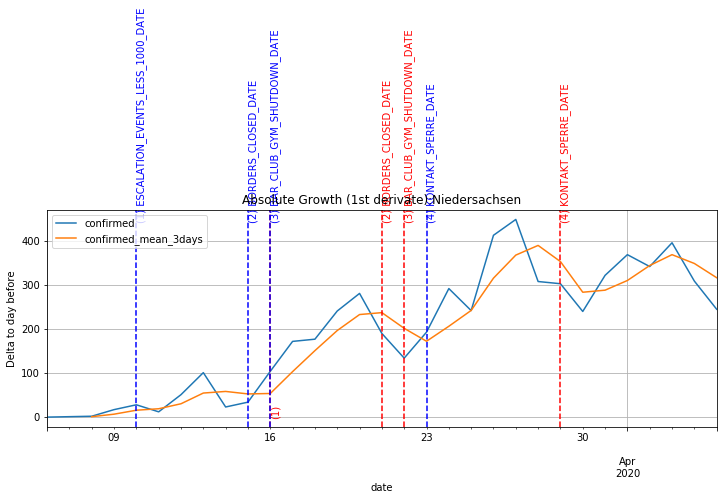

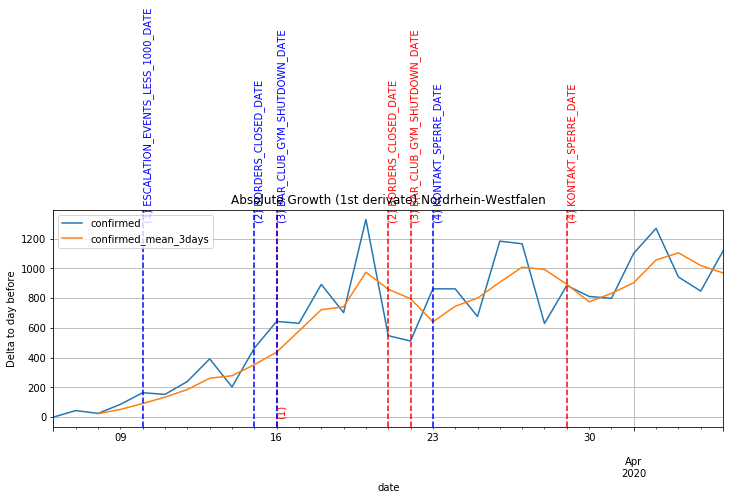

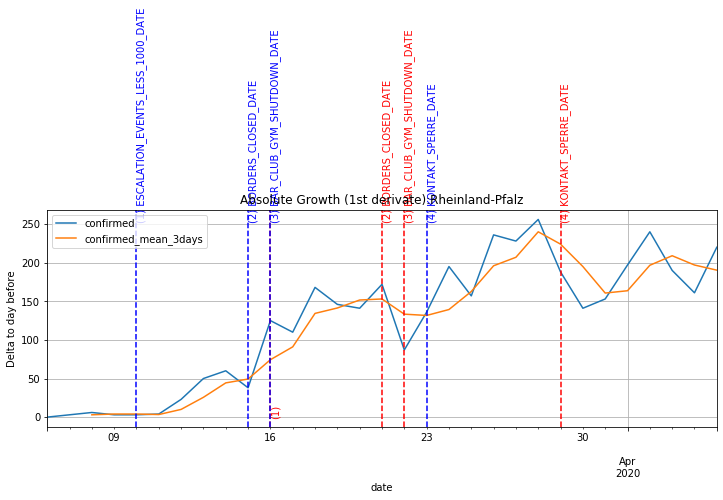

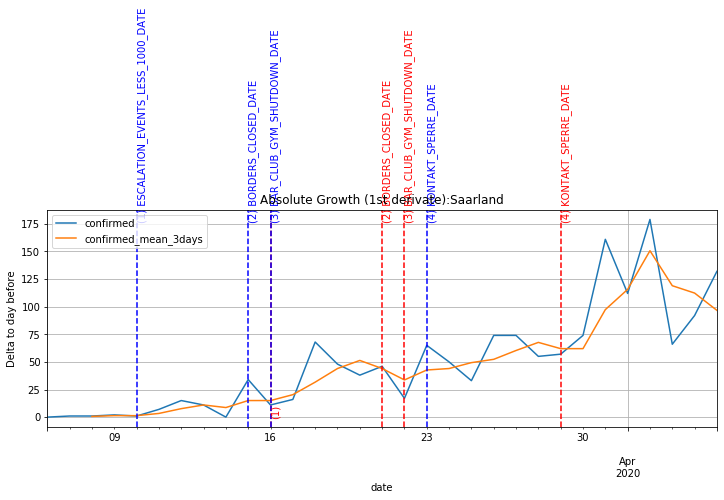

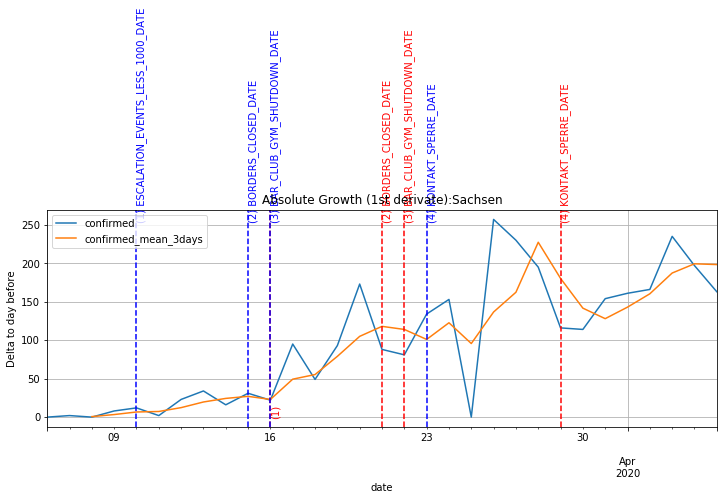

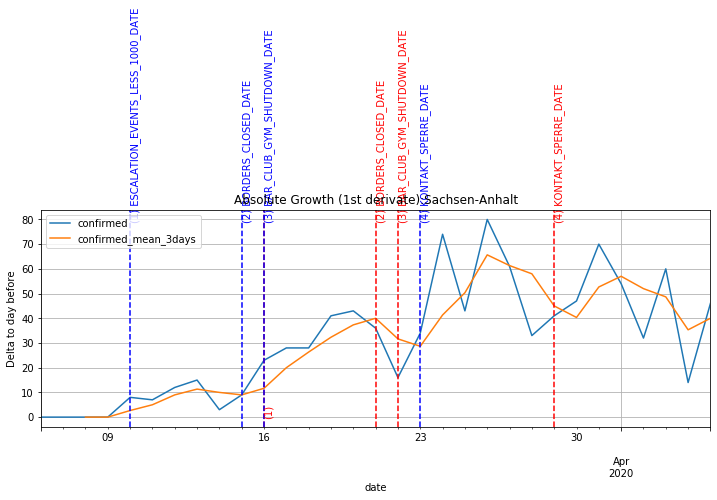

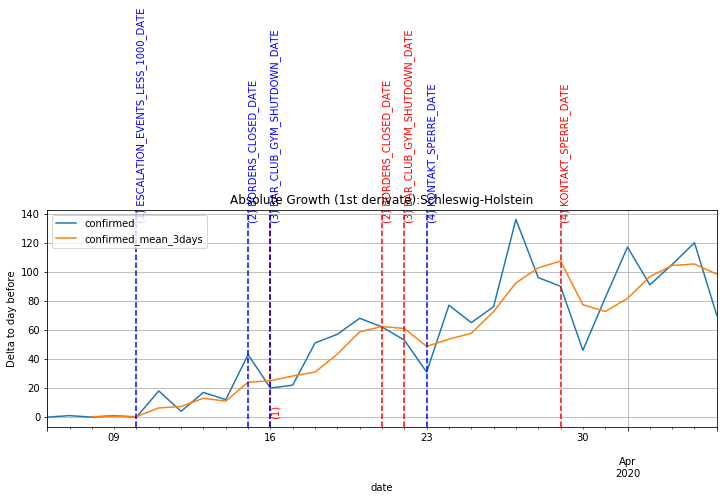

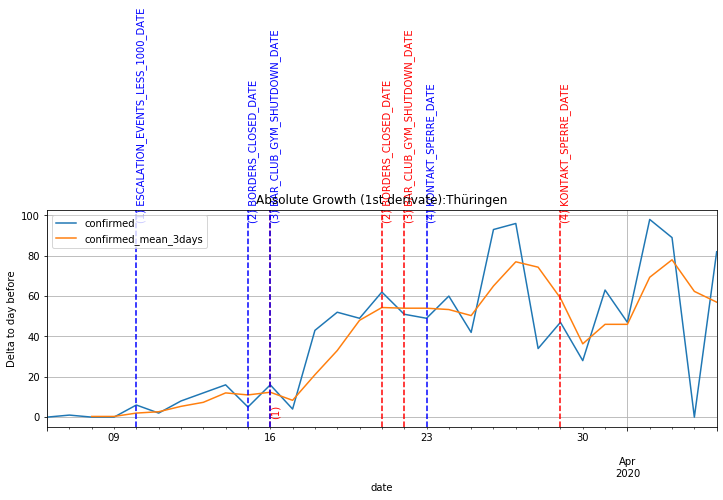

In [114]:
for fed in feds:
    fed_confirmed_by_date=de_fed_by_date.loc[de_fed_by_date.label==fed,['date','confirmed']].set_index('date')
    abs_growth = abs_growth_from(fed_confirmed_by_date)
    ax = plot_abs_growth_confirmed(abs_growth, fed)
    plot_events(ax, abs_growth.max())

## Growth Factor

In [115]:
def rolling_mean(days, df_confirmed_by_date, fed):
    fed_confirmed_by_date=df_confirmed_by_date.loc[df_confirmed_by_date.label==fed,['date','confirmed']].set_index('date')
    fed_confirmed_by_date['confirmed_mean_3days'] = fed_confirmed_by_date.rolling(days).mean()    
    return fed_confirmed_by_date

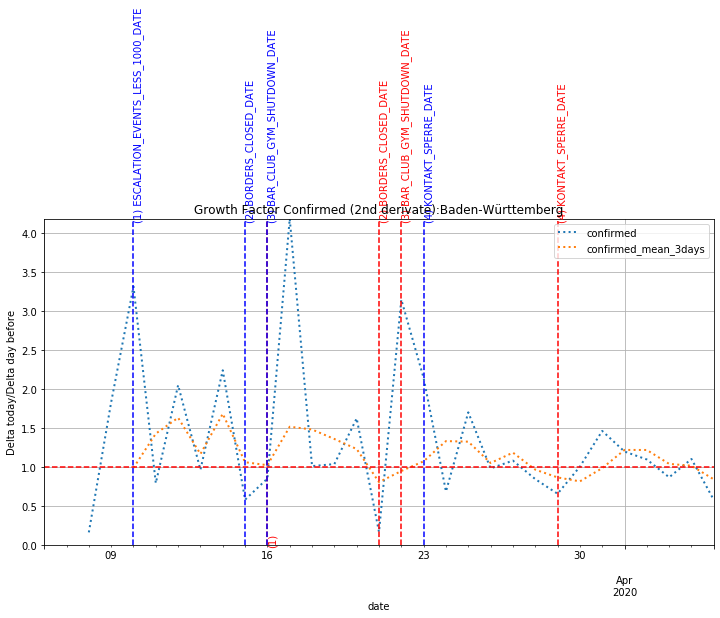

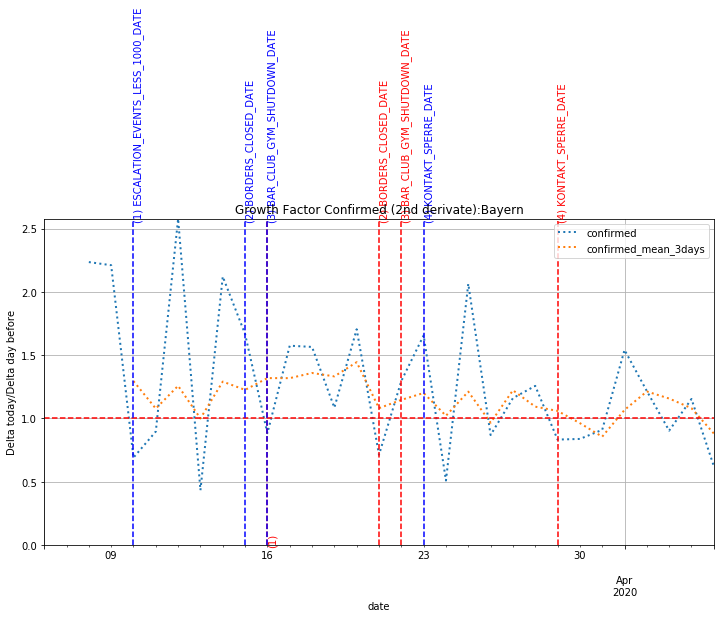

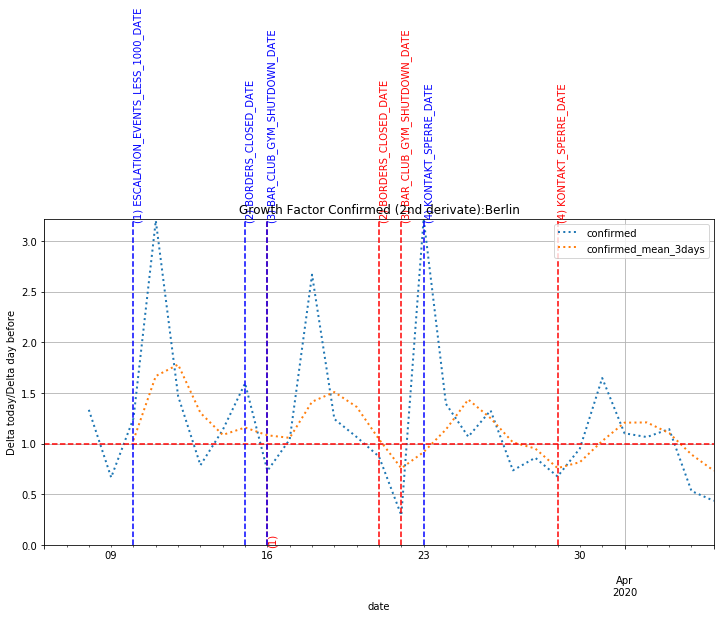

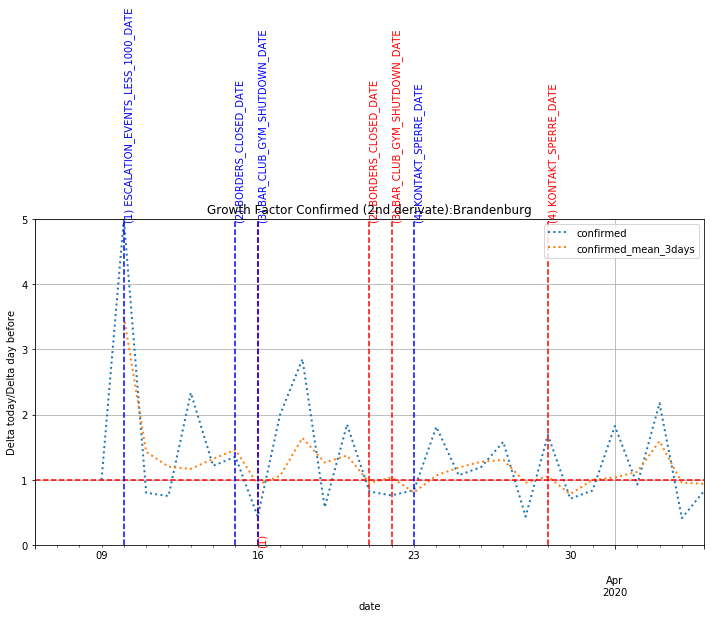

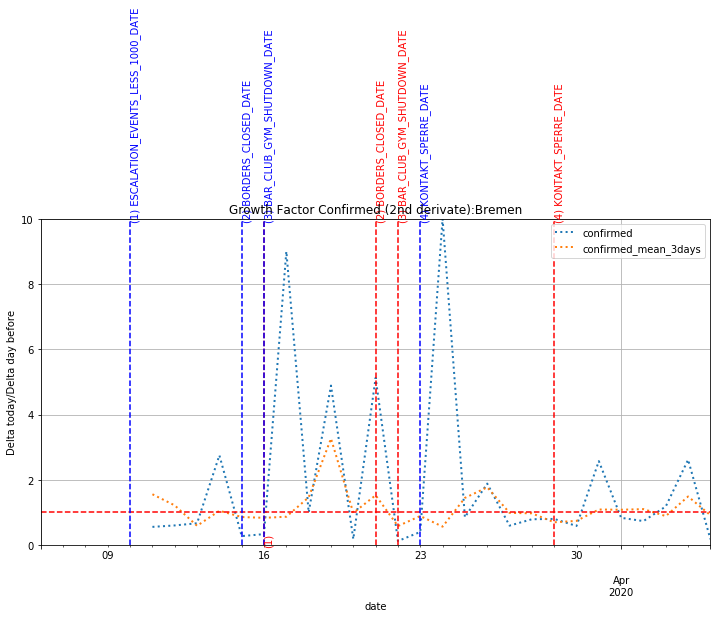

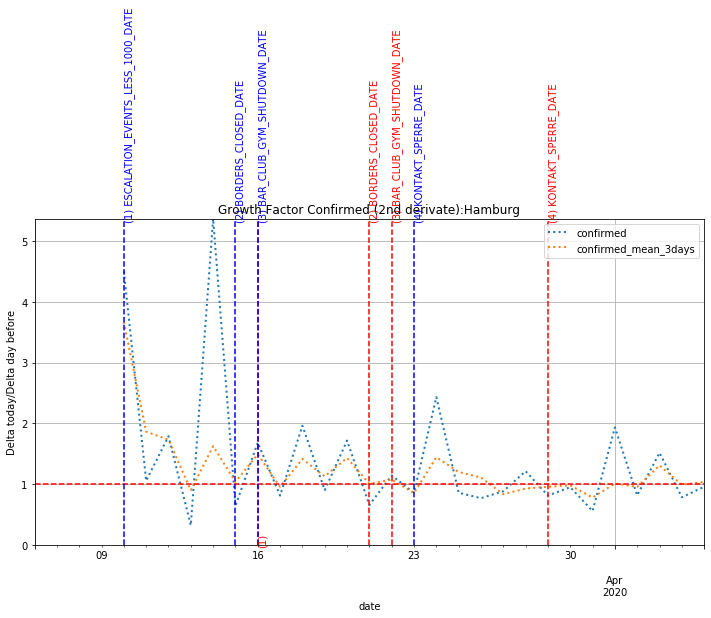

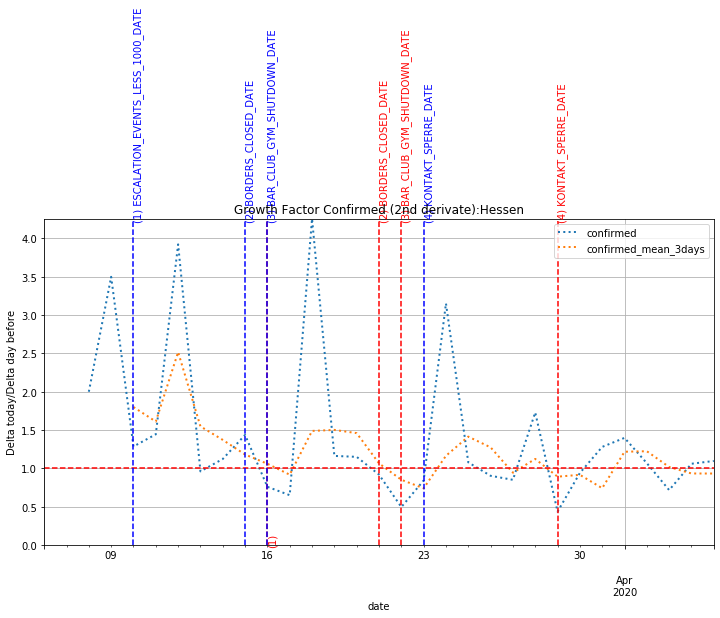

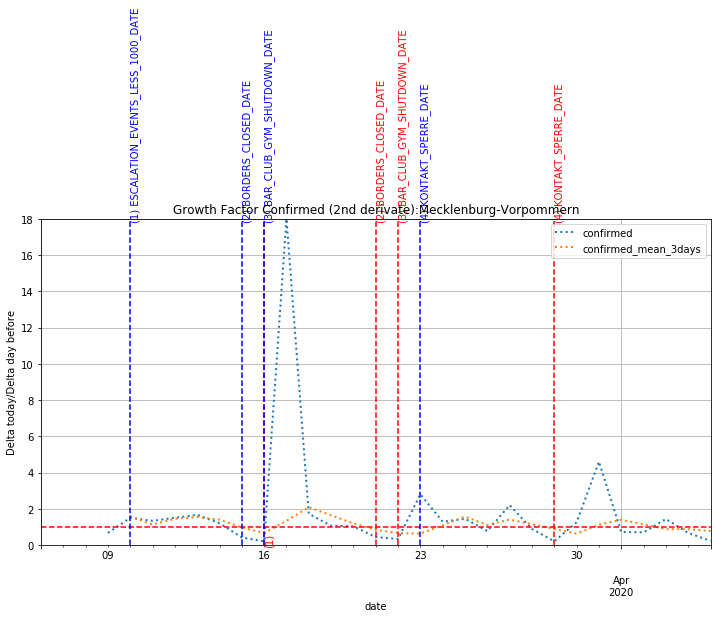

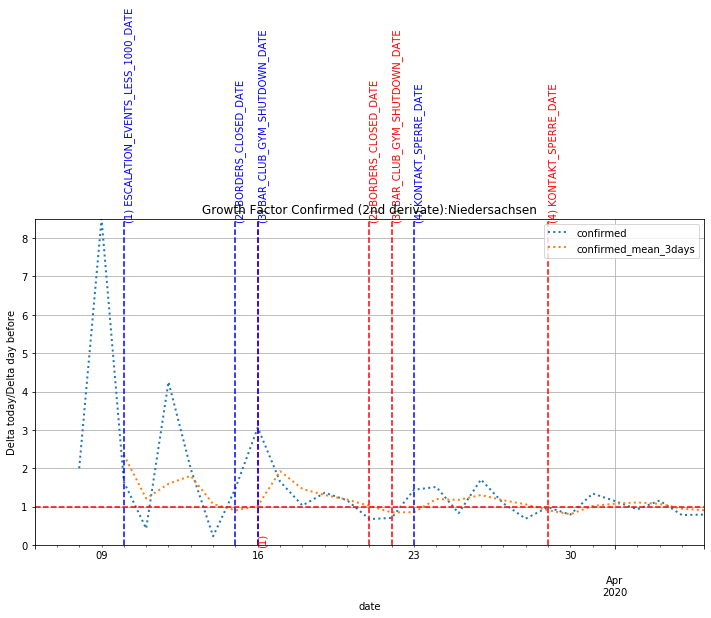

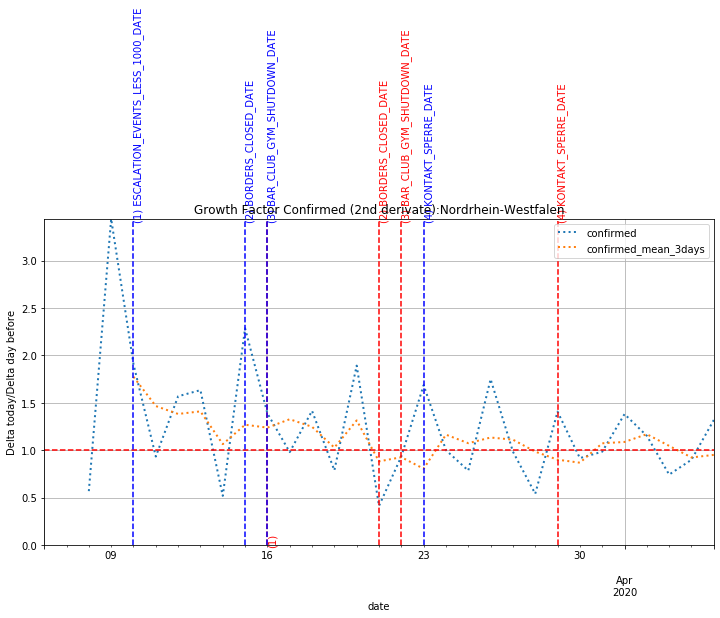

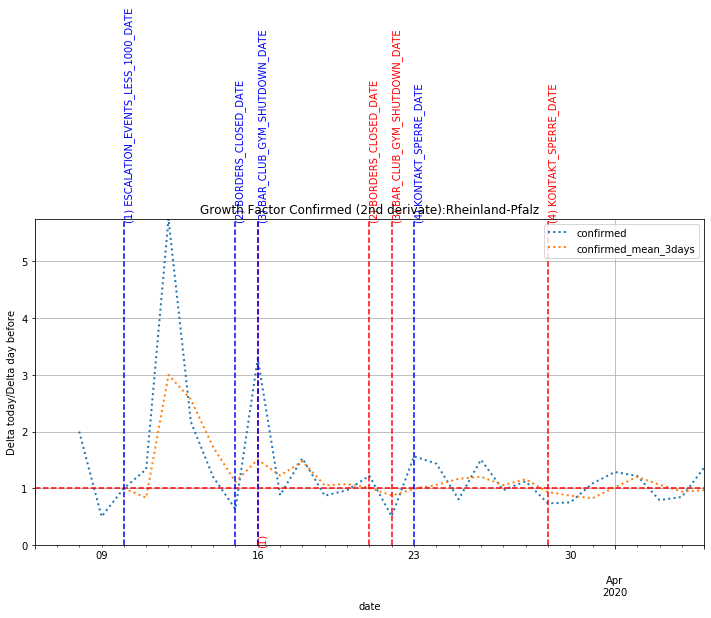

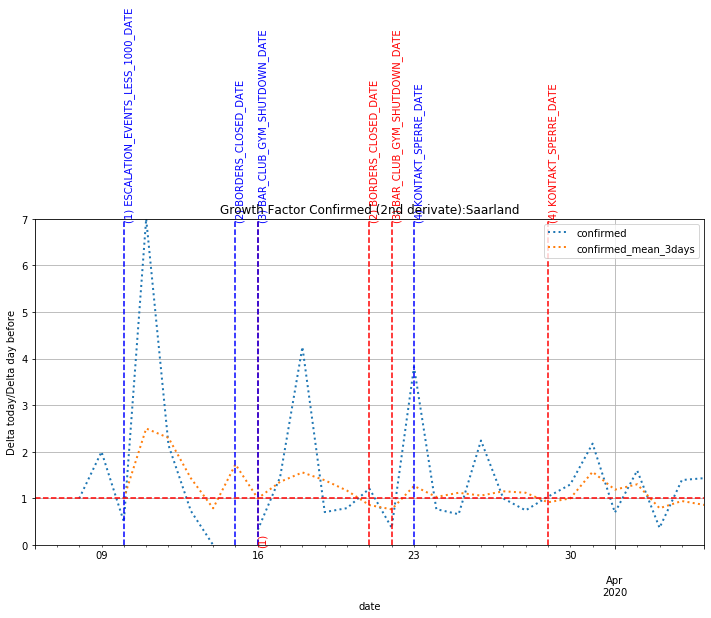

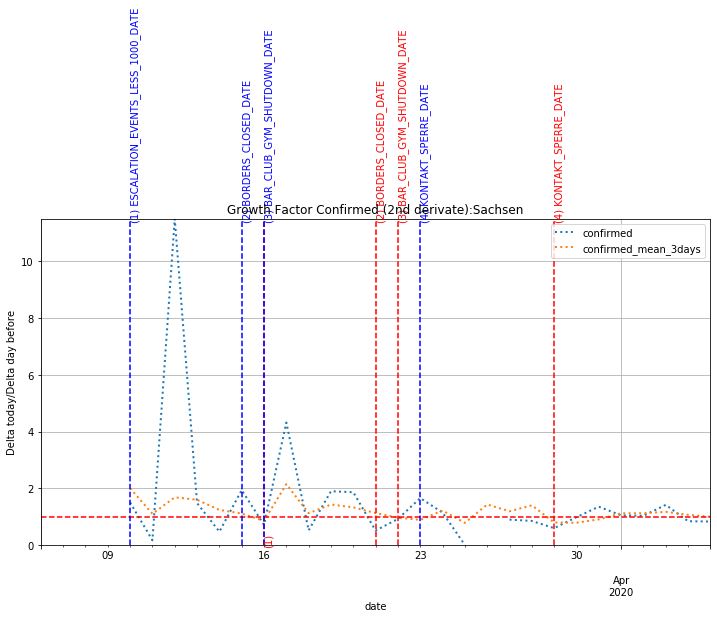

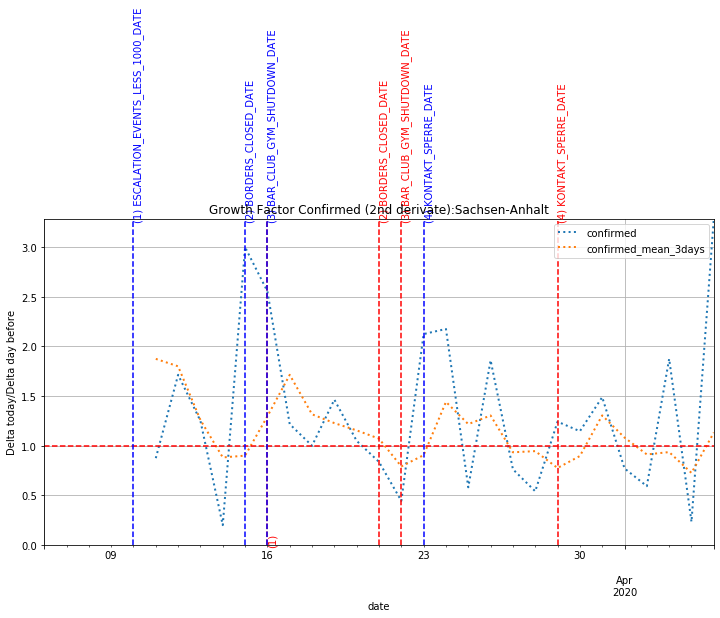

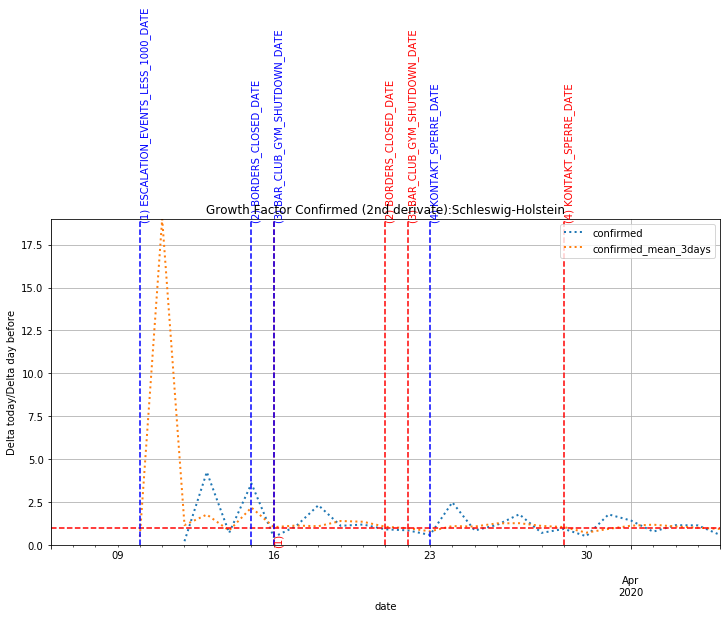

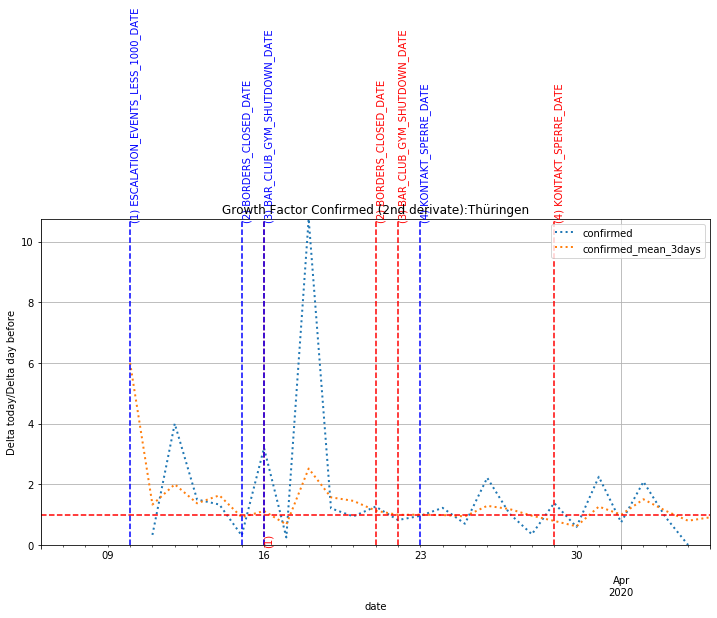

In [116]:
for fed in feds:
    fed_confirmed_by_date = rolling_mean(3, de_fed_by_date, fed)
    gf = growth_factor_from(abs_growth_from(fed_confirmed_by_date))

    # fed_confirmed_by_date=de_fed_by_date.loc[de_fed_by_date.label==fed,['date','confirmed']].set_index('date')
    # abs_growth = abs_growth_from(fed_confirmed_by_date)
    # gf = growth_factor_from(abs_growth[['confirmed']])
    gf = gf[gf<1000]
    if gf.size>0:
        ax = plot_growth_factor(gf, gf.max().max(), fed)
        plot_events(ax,gf.max().max())
        pyplot.show()